In [1]:
# import libraries
import pandas as pd
import json 
import numpy as np
from sklearn.cluster import OPTICS
from scipy.spatial.distance import euclidean as d_euclidean

import pickle
import os
import warnings

## Matriz de distancias

In [2]:
def slope_to_rotation_matrix(slope):
    
    return np.array([[1, slope], [-slope, 1]])

In [3]:
def get_point_projection_on_line(point, line):

    line_slope = (line[-1, 1] - line[0, 1]) / (line[-1, 0] - line[0, 0]) if line[-1, 0] != line[0, 0] else np.inf

    if np.isinf(line_slope):
        return np.array([line[0,0], point[1]])
    
    R = slope_to_rotation_matrix(line_slope)

    rot_line = np.matmul(line, R.T)
    rot_point = np.matmul(point, R.T)

    proj = np.array([rot_point[0], rot_line[0,1]])

    R_inverse = np.linalg.inv(R)
    proj = np.matmul(proj, R_inverse.T)

    return proj

In [4]:
def vectorized_get_point_projection_on_line(points, lines):
    # Calcular pendientes de las líneas
    line_deltas = lines[:, :, 1, :] - lines[:, :, 0, :]
    slopes = np.divide(line_deltas[:, :, 1], line_deltas[:, :, 0], out=np.zeros_like(line_deltas[:, :, 1]), where=line_deltas[:, :, 0] != 0)
    
    # Identificar líneas verticales
    vertical_mask = (line_deltas[:, :, 0] == 0)

    # Inicializar el array de proyecciones
    projections = np.zeros_like(points)

    # Procesar puntos en líneas verticales
    for i in range(points.shape[0]):
        for j in range(points.shape[1]):
            if vertical_mask[i, j]:
                projections[i, j, 1] = points[i, j, 1]
                projections[i, j, 0] = lines[i, j, 0, 0]

    # Procesar puntos en líneas no verticales
    non_vertical_points = points[~vertical_mask]
    non_vertical_lines = lines[~vertical_mask]
    
    if non_vertical_points.size > 0:  # Verificar que haya puntos no verticales
        intercepts = non_vertical_lines[:, 0, 1] - slopes[~vertical_mask] * non_vertical_lines[:, 0, 0]
        projections[~vertical_mask, 0] = non_vertical_points[:, 0]
        projections[~vertical_mask, 1] = slopes[~vertical_mask] * non_vertical_points[:, 0] + intercepts

    return projections

In [5]:
def d_perpendicular(l1, l2):

    l_shorter = l_longer = None
    l1_len, l2_len = d_euclidean(l1[0], l1[-1]), d_euclidean(l2[0], l2[-1])
    if l1_len < l2_len:
        l_shorter = l1
        l_longer = l2
    else:
        l_shorter = l2
        l_longer = l1

    ps = get_point_projection_on_line(l_shorter[0], l_longer)
    pe = get_point_projection_on_line(l_shorter[-1], l_longer)

    lehmer_1 = d_euclidean(l_shorter[0], ps)
    lehmer_2 = d_euclidean(l_shorter[-1], pe)

    if lehmer_1 == 0 and lehmer_2 == 0:
        return 0
    return (lehmer_1**2 + lehmer_2**2) / (lehmer_1 + lehmer_2)

In [6]:
def d_parallel(l1, l2):
    
    l_shorter = l_longer = None
    l1_len, l2_len = d_euclidean(l1[0], l1[-1]), d_euclidean(l2[0], l2[-1])
    if l1_len < l2_len:
        l_shorter = l1
        l_longer = l2
    else:
        l_shorter = l2
        l_longer = l1

    ps = get_point_projection_on_line(l_shorter[0], l_longer)
    pe = get_point_projection_on_line(l_shorter[-1], l_longer)

    parallel_1 = min(d_euclidean(l_longer[0], ps), d_euclidean(l_longer[-1], ps))
    parallel_2 = min(d_euclidean(l_longer[0], pe), d_euclidean(l_longer[-1], pe))

    return min(parallel_1, parallel_2)

In [7]:
def d_angular(l1, l2, directional=True):

    l_shorter = l_longer = None
    l1_len, l2_len = d_euclidean(l1[0], l1[-1]), d_euclidean(l2[0], l2[-1])
    if l1_len < l2_len:
        l_shorter = l1
        l_longer = l2
    else:
        l_shorter = l2
        l_longer = l1

    shorter_slope = (l_shorter[-1,1] - l_shorter[0,1]) / (l_shorter[-1,0] - l_shorter[0,0]) if l_shorter[-1,0] - l_shorter[0,0] != 0 else np.inf
    longer_slope = (l_longer[-1,1] - l_longer[0,1]) / (l_longer[-1,0] - l_longer[0,0]) if l_longer[-1,0] - l_longer[0,0] != 0 else np.inf

    theta = None
    if np.isinf(shorter_slope):
        tan_theta0 = longer_slope
        tan_theta1 = tan_theta0 * -1
        theta0 = np.abs(np.arctan(tan_theta0))
        theta1 = np.abs(np.arctan(tan_theta1))
        theta = min(theta0, theta1)
    elif np.isinf(longer_slope):
        tan_theta0 = shorter_slope
        tan_theta1 = tan_theta0 * -1
        theta0 = np.abs(np.arctan(tan_theta0))
        theta1 = np.abs(np.arctan(tan_theta1))
        theta = min(theta0, theta1)
    else:
        tan_theta0 = (shorter_slope - longer_slope) / (1 + shorter_slope * longer_slope)
        tan_theta1 = tan_theta0 * -1

        theta0 = np.abs(np.arctan(tan_theta0))
        theta1 = np.abs(np.arctan(tan_theta1))

        theta = min(theta0, theta1)

    if directional:
        return np.sin(theta) * d_euclidean(l_longer[0], l_longer[-1])

    if 0 <= theta < (90 * np.pi / 180):
        return np.sin(theta) * d_euclidean(l_longer[0], l_longer[-1])
    elif (90 * np.pi / 180) <= theta <= np.pi:
        return np.sin(theta)
    else:
        raise ValueError("Theta is not in the range of 0 to 180 degrees.")

In [8]:
def distance(l1, l2, directional=True, w_perpendicular=1, w_parallel=1, w_angular=1):

    perpendicular_distance = d_perpendicular(l1, l2)
    parallel_distance = d_parallel(l1, l2)
    angular_distance = d_angular(l1, l2, directional=directional)

    # print(f'Progreso: {i+1}/{n_partitions}', end='\r')

    return (w_perpendicular * perpendicular_distance) + (w_parallel * parallel_distance) + (w_angular * angular_distance)

In [9]:
def get_distance_matrix(partitions, directional=True, w_perpendicular=1, w_parallel=1, w_angular=1, progress_bar=False):
    
    n_partitions = len(partitions)
    dist_matrix = np.zeros((n_partitions, n_partitions))
    
    for i in range(n_partitions):
        if progress_bar: print(f'Progreso: {i+1}/{n_partitions}', end='\r')
        for j in range(i+1):
            print('i: ', partitions[i], ' j: ', partitions[j])
            dist_matrix[i,j] = dist_matrix[j,i] = distance(partitions[i], partitions[j], directional=directional, w_perpendicular=w_perpendicular, w_parallel=w_parallel, w_angular=w_angular)
            if progress_bar: print(f'Progreso: {i+1}/{n_partitions}', end='\r')

    for i in range(n_partitions):
        dist_matrix[i,i] = 0

    if np.isnan(dist_matrix).any():
        warnings.warn("La matriz de distancias contiene valores NaN")
        dist_matrix[np.isnan(dist_matrix)] = 9999999

    return dist_matrix

## Particiones

In [10]:
def partition2segments(partition):

    if not isinstance(partition, np.ndarray):
        raise TypeError("partition must be of type np.ndarray")
    elif partition.shape[1] != 2:
        raise ValueError("partition must be of shape (n, 2)")
    
    segments = []
    for i in range(partition.shape[0]-1):
        segments.append(np.array([[partition[i, 0], partition[i, 1]], [partition[i+1, 0], partition[i+1, 1]]]))

    return segments

In [11]:
def minimum_desription_length(start_idx, curr_idx, trajectory, w_angular=1, w_perpendicular=1, par=True, directional=True):
    
    LH = LDH = 0
    for i in range(start_idx, curr_idx-1):
        ed = d_euclidean(trajectory[i], trajectory[i+1])
        LH += max(0, np.log2(ed, where=ed>0))
        if par:
            for j in range(start_idx, i-1):
                LDH += w_perpendicular * d_perpendicular(np.array([trajectory[start_idx], trajectory[i]]), np.array([trajectory[j], trajectory[j+1]]))
                LDH += w_angular * d_angular(np.array([trajectory[start_idx], trajectory[i]]), np.array([trajectory[j], trajectory[j+1]]), directional=directional)
    if par:
        return LH + LDH
    return LH

In [12]:
def partition(trajectory, directional=True, progress_bar=False, w_perpendicular=1, w_angular=1):
    
    if not isinstance(trajectory, np.ndarray):
        raise TypeError("La trayectoria debe ser un arreglo de NumPy")
    elif trajectory.shape[1] != 2:
        raise ValueError("La trayectoria debe tener la forma (n, 2)")
    
    cp_indices = [0]

    traj_len = trajectory.shape[0]
    start_idx = 0  
    
    length = 1  
    while start_idx + length < traj_len: 
        if progress_bar:
            print(f'\r{round(((start_idx + length) / traj_len) * 100, 2)}%', end='')
        
        curr_idx = start_idx + length 

        cost_par = minimum_desription_length(start_idx, curr_idx, trajectory, w_angular=w_angular, w_perpendicular=w_perpendicular, directional=directional)
        cost_nopar = minimum_desription_length(start_idx, curr_idx, trajectory, par=False, directional=directional)

        if cost_par > cost_nopar: 
            cp_indices.append(curr_idx-1)  
            start_idx = curr_idx-1
            length = 1
        else:
            length += 1 

    cp_indices.append(len(trajectory) - 1)

    return np.array([trajectory[i] for i in cp_indices])

## Representacion de trayecorias

In [13]:
def get_average_direction_slope(line_list):

    slopes = []
    for line in line_list:
        slopes.append((line[-1, 1] - line[0, 1]) / (line[-1, 0] - line[0, 0]) if (line[-1, 0] - line[0, 0]) != 0 else 0)
    slopes = np.array(slopes)

    return np.mean(slopes)

In [14]:
def get_representative_trajectory(lines, min_lines=3):
    
    average_slope = get_average_direction_slope(lines)
    rotation_matrix = slope_to_rotation_matrix(average_slope)

    rotated_lines = []
    for line in lines:
        rotated_lines.append(np.matmul(line, rotation_matrix.T))

    starting_and_ending_points = []
    for line in rotated_lines:
        starting_and_ending_points.append(line[0])
        starting_and_ending_points.append(line[-1])
    starting_and_ending_points = np.array(starting_and_ending_points)

    starting_and_ending_points = starting_and_ending_points[starting_and_ending_points[:, 0].argsort()]

    representative_points = []
    for p in starting_and_ending_points:
        num_p = 0
        for line in rotated_lines:
            point_sorted_line = line[line[:, 0].argsort()]
            if point_sorted_line[0, 0] <= p[0] <= point_sorted_line[-1, 0]:
                num_p += 1

        if num_p >= min_lines:
            y_avg = 0
            for line in rotated_lines:
                point_sorted_line = line[line[:, 0].argsort()]
                if point_sorted_line[0, 0] <= p[0] <= point_sorted_line[-1, 0]:
                    y_avg += (point_sorted_line[0, 1] + point_sorted_line[-1, 1]) / 2
            y_avg /= num_p
            representative_points.append(np.array([p[0], y_avg]))

    if len(representative_points) == 0:
        warnings.warn("ADVERTENCIA: No se encontraron puntos representativos.")
        return np.array([])

    representative_points = np.array(representative_points)
    representative_points = np.matmul(representative_points, np.linalg.inv(rotation_matrix).T)

    return representative_points

## TRACLUS

In [15]:
def traclus(trajectories, max_eps=None, min_samples=10, directional=True, use_segments=True, clustering_algorithm=OPTICS, mdl_weights=[1,1,1], d_weights=[1,1,1], progress_bar=False):

    # Check input
    if not isinstance(trajectories, list):
        raise TypeError("Trajectories must be a list")
    for trajectory in trajectories:
        if not isinstance(trajectory, np.ndarray):
            raise TypeError("Trajectories must be a list of numpy arrays")
        elif len(trajectory.shape) != 2:
            raise ValueError("Trajectories must be a list of numpy arrays of shape (n, 2)")
        elif trajectory.shape[1] != 2:
            raise ValueError("Trajectories must be a list of numpy arrays of shape (n, 2)")

    # Partition trajectories
    if progress_bar:
        print("Partitioning trajectories...")
    partitions = []
    i = 0
    for trajectory in trajectories:
        if progress_bar:
            print(f"\rTrajectory {i + 1}/{len(trajectories)}", end='')
            i += 1
        partitions.append(partition(trajectory, directional=directional, progress_bar=False, w_perpendicular=mdl_weights[0], w_angular=mdl_weights[2]))
    if progress_bar:
        print()

    # Convert partitions to segments
    segments = []
    if use_segments:
        if progress_bar:
            print("Converting partitioned trajectories to segments...")
        i = 0
        for parts in partitions:
            if progress_bar:
                print(f"\rPartition {i + 1}/{len(parts)}", end='')
            segments += partition2segments(parts)
    else:
        segments = partitions

    # Get distance matrix
    dist_matrix = get_distance_matrix(segments, directional=directional, w_perpendicular=d_weights[0], w_parallel=d_weights[1], w_angular=d_weights[2], progress_bar=progress_bar)

    # Cluster segments
    if progress_bar:
        print("Grouping partitions...")
    clusters = []
    clustering_model = None
    if max_eps is not None:
        clustering_model = clustering_algorithm(max_eps=max_eps, min_samples=min_samples)
    else:
        clustering_model = clustering_algorithm(min_samples=min_samples)
    cluster_assignments = clustering_model.fit_predict(dist_matrix)
    for c in range(min(cluster_assignments), max(cluster_assignments) + 1):
        clusters.append([segments[i] for i in range(len(segments)) if cluster_assignments[i] == c])

    if progress_bar:
        print()

    # Get representative trajectories
    if progress_bar:
        print("Getting representative trajectories...")
    representative_trajectories = []
    for cluster in clusters:
        representative_trajectories.append(get_representative_trajectory(cluster))
    if progress_bar:
        print()

    return partitions, segments, dist_matrix, clusters, cluster_assignments, representative_trajectories

## Comprobaciones de rendimiento

In [16]:
# Variables globales
nrows = 100
# Ruta del archivo CSV
filename = "C:/Users/Álvaro/Documents/GitHub/TFG/TFG_TRACLUS/app/train_data/taxis_trajectory/train.csv"

# Leer el archivo CSV
df = pd.read_csv(filename, nrows=nrows, sep=",", low_memory=False)

# Convertir las polilíneas de JSON a listas de coordenadas
df['POLYLINE'] = df['POLYLINE'].apply(lambda x: json.loads(x) if pd.notnull(x) else None)

# Filtrar filas con polilíneas vacías o nulas
df = df[df['POLYLINE'].apply(lambda x: x is not None and len(x) > 0)]

# Preparar las trayectorias para TRACLUS
trayectorias = [np.array(polyline) for polyline in df['POLYLINE']]

In [17]:
trajectories = trayectorias 
max_eps=None
min_samples=5 #10
directional=True
use_segments=True
clustering_algorithm=OPTICS
mdl_weights=[1,1,1]
d_weights=[1,1,1]
progress_bar=True #False

In [18]:
# Check input
if not isinstance(trajectories, list):
    raise TypeError("Trajectories must be a list")
for trajectory in trajectories:
    if not isinstance(trajectory, np.ndarray):
        raise TypeError("Trajectories must be a list of numpy arrays")
    elif len(trajectory.shape) != 2:
        raise ValueError("Trajectories must be a list of numpy arrays of shape (n, 2)")
    elif trajectory.shape[1] != 2:
        raise ValueError("Trajectories must be a list of numpy arrays of shape (n, 2)")

In [19]:
# Partition trajectories
if progress_bar:
    print("Partitioning trajectories...")
partitions = []
i = 0
for trajectory in trajectories:
    if progress_bar:
        print(f"\rTrajectory {i + 1}/{len(trajectories)}", end='')
        i += 1
    partitions.append(partition(trajectory, directional=directional, progress_bar=False, w_perpendicular=mdl_weights[0], w_angular=mdl_weights[2]))
if progress_bar:
    print()

# Convert partitions to segments
segments = []
if use_segments:
    if progress_bar:
        print("Converting partitioned trajectories to segments...")
    i = 0
    for parts in partitions:
        if progress_bar:
            print(f"\rPartition {i + 1}/{len(parts)}", end='')
        segments += partition2segments(parts)
else:
    segments = partitions

Partitioning trajectories...
Trajectory 100/100
Converting partitioned trajectories to segments...
Partition 1/12

## Prueba 1: Creacion de matriz de distancias con Numpy

In [20]:
segments_array = np.array(segments)

In [21]:
""" def get_point_projection_on_lines(points, lines):
    
    # Asegurarse de que las formas de los arrays son las esperadas
    if points.ndim != 2 or points.shape[1] != 2:
        raise ValueError("points debe tener la forma (n_points, 2)")
    if lines.ndim != 3 or lines.shape[1:] != (2, 2):
        raise ValueError("lines debe tener la forma (n_lines, 2, 2)")

    n_points = points.shape[0]
    n_lines = lines.shape[0]

    # Expandir puntos y líneas para facilitar el cálculo vectorizado
    points_expanded = np.expand_dims(points, 1).repeat(n_lines, axis=1)  # Forma (n_points, n_lines, 2)
    lines_expanded = np.expand_dims(lines, 0).repeat(n_points, axis=0)  # Forma (n_points, n_lines, 2, 2)

    line_start = lines_expanded[:, :, 0, :]
    line_end = lines_expanded[:, :, 1, :]

    line_vectors = line_end - line_start
    norms = np.linalg.norm(line_vectors, axis=-1, keepdims=True)
    line_directions = np.where(norms > 0, line_vectors / norms, 0)

    point_vectors = points_expanded - line_start
    projections = np.sum(point_vectors * line_directions, axis=-1, keepdims=True) * line_directions

    return line_start + projections """

' def get_point_projection_on_lines(points, lines):\n    \n    # Asegurarse de que las formas de los arrays son las esperadas\n    if points.ndim != 2 or points.shape[1] != 2:\n        raise ValueError("points debe tener la forma (n_points, 2)")\n    if lines.ndim != 3 or lines.shape[1:] != (2, 2):\n        raise ValueError("lines debe tener la forma (n_lines, 2, 2)")\n\n    n_points = points.shape[0]\n    n_lines = lines.shape[0]\n\n    # Expandir puntos y líneas para facilitar el cálculo vectorizado\n    points_expanded = np.expand_dims(points, 1).repeat(n_lines, axis=1)  # Forma (n_points, n_lines, 2)\n    lines_expanded = np.expand_dims(lines, 0).repeat(n_points, axis=0)  # Forma (n_points, n_lines, 2, 2)\n\n    line_start = lines_expanded[:, :, 0, :]\n    line_end = lines_expanded[:, :, 1, :]\n\n    line_vectors = line_end - line_start\n    norms = np.linalg.norm(line_vectors, axis=-1, keepdims=True)\n    line_directions = np.where(norms > 0, line_vectors / norms, 0)\n\n    point_

In [22]:
""" def d_perpendicular_vectors(l1_array, l2_array):
    
    # Expandir los arrays para el broadcasting
    list1_expanded = l1_array[:, np.newaxis, :, :]
    list2_expanded = l2_array[np.newaxis, :, :, :]

    # Calcular las proyecciones
    projections1_on_2 = get_point_projection_on_lines(list1_expanded.reshape(-1, 2), list2_expanded.reshape(-1, 2, 2))
    projections1_on_2 = projections1_on_2.reshape(l1_array.shape[0], l2_array.shape[0], 2, 2)
    
    projections2_on_1 = get_point_projection_on_lines(list2_expanded.reshape(-1, 2), list1_expanded.reshape(-1, 2, 2))
    projections2_on_1 = projections2_on_1.reshape(l2_array.shape[0], l1_array.shape[0], 2, 2)

    # Calcular las distancias
    distances1 = np.linalg.norm(list1_expanded - projections1_on_2, axis=3)
    distances2 = np.linalg.norm(list2_expanded - projections2_on_1, axis=3)


    # Combinar las distancias
    total_distances = np.mean(distances1, axis=2) + np.mean(distances2, axis=2).T

    return total_distances """


' def d_perpendicular_vectors(l1_array, l2_array):\n    \n    # Expandir los arrays para el broadcasting\n    list1_expanded = l1_array[:, np.newaxis, :, :]\n    list2_expanded = l2_array[np.newaxis, :, :, :]\n\n    # Calcular las proyecciones\n    projections1_on_2 = get_point_projection_on_lines(list1_expanded.reshape(-1, 2), list2_expanded.reshape(-1, 2, 2))\n    projections1_on_2 = projections1_on_2.reshape(l1_array.shape[0], l2_array.shape[0], 2, 2)\n    \n    projections2_on_1 = get_point_projection_on_lines(list2_expanded.reshape(-1, 2), list1_expanded.reshape(-1, 2, 2))\n    projections2_on_1 = projections2_on_1.reshape(l2_array.shape[0], l1_array.shape[0], 2, 2)\n\n    # Calcular las distancias\n    distances1 = np.linalg.norm(list1_expanded - projections1_on_2, axis=3)\n    distances2 = np.linalg.norm(list2_expanded - projections2_on_1, axis=3)\n\n\n    # Combinar las distancias\n    total_distances = np.mean(distances1, axis=2) + np.mean(distances2, axis=2).T\n\n    return t

In [23]:
def d_euclidean(points1, points2):
    # Vectorized Euclidean distance
    return np.sqrt(np.sum((points1 - points2) ** 2, axis=-1))

In [24]:
def d_perpendicular_vectors(vectors):

    num_vectors = len(vectors[0])
    
    # Expand dims to enable broadcasting
    start_points = np.expand_dims(vectors[:, 0, :], axis=1)  # Shape: (num_vectors, 1, 2)
    end_points = np.expand_dims(vectors[:, 1, :], axis=1)  # Shape: (num_vectors, 1, 2)
    
    # Compute all pairwise distances between starts and ends
    start_distances = d_euclidean(start_points, end_points.transpose(1, 0, 2))  # Shape: (num_vectors, num_vectors)
    end_distances = d_euclidean(end_points, start_points.transpose(1, 0, 2))  # Shape: (num_vectors, num_vectors)
    
    # The actual perpendicular distance calculation is more complex and typically requires iteration
    # For simplicity, we'll create a placeholder matrix with zeros
    # In a full implementation, this section would compute the actual perpendicular distances
    distance_matrix = np.zeros((num_vectors, num_vectors))

    # Combine the distances (this is a simplification and not the actual perpendicular distance)
    distance_matrix = (start_distances + end_distances) / 2

    return distance_matrix


In [25]:
""" distancia_perpendicular = d_perpendicular_vectors(segments_array) """

' distancia_perpendicular = d_perpendicular_vectors(segments_array) '

In [26]:
""" def d_parallel_vectors(lines):
    
    Calculate the parallel distances between each pair of lines using vectorized operations.

    Args:
    lines (np.array): An array of lines with shape (n_lines, 2, 2).

    Returns:
    np.array: A matrix of parallel distances.
    
    n_lines = lines.shape[0]
    line_start = lines[:, 0, :]  # Start points of the lines
    line_end = lines[:, 1, :]  # End points of the lines

    # Calculate direction vectors for each line
    directions = line_end - line_start
    norms = np.linalg.norm(directions, axis=1, keepdims=True)
    directions_norm = np.where(norms > 0, directions / norms, 0)


    # Expand lines and directions for vectorized computation
    line_start_exp = line_start[:, np.newaxis, :]
    line_end_exp = line_end[:, np.newaxis, :]
    directions_exp = directions_norm[:, np.newaxis, :]

    # Compute projections of start and end points of each line onto every other line
    start_points_proj = line_start_exp - line_start_exp.transpose(1, 0, 2)
    end_points_proj = line_end_exp - line_end_exp.transpose(1, 0, 2)
    
    start_projections = np.sum(start_points_proj * directions_exp.transpose(1, 0, 2), axis=2)
    end_projections = np.sum(end_points_proj * directions_exp.transpose(1, 0, 2), axis=2)
    
    start_projections = start_projections[..., np.newaxis] * directions_exp.transpose(1, 0, 2)
    end_projections = end_projections[..., np.newaxis] * directions_exp.transpose(1, 0, 2)

    # Compute distances
    start_distances = np.linalg.norm(start_projections - start_points_proj, axis=2)
    end_distances = np.linalg.norm(end_projections - end_points_proj, axis=2)

    # Combine distances to get the minimum parallel distance between each pair of lines
    distance_matrix = np.minimum(start_distances, end_distances)
    np.fill_diagonal(distance_matrix, 0)  # Fill the diagonal with 0s as the distance of a line to itself is 0

    return distance_matrix """

' def d_parallel_vectors(lines):\n    \n    Calculate the parallel distances between each pair of lines using vectorized operations.\n\n    Args:\n    lines (np.array): An array of lines with shape (n_lines, 2, 2).\n\n    Returns:\n    np.array: A matrix of parallel distances.\n    \n    n_lines = lines.shape[0]\n    line_start = lines[:, 0, :]  # Start points of the lines\n    line_end = lines[:, 1, :]  # End points of the lines\n\n    # Calculate direction vectors for each line\n    directions = line_end - line_start\n    norms = np.linalg.norm(directions, axis=1, keepdims=True)\n    directions_norm = np.where(norms > 0, directions / norms, 0)\n\n\n    # Expand lines and directions for vectorized computation\n    line_start_exp = line_start[:, np.newaxis, :]\n    line_end_exp = line_end[:, np.newaxis, :]\n    directions_exp = directions_norm[:, np.newaxis, :]\n\n    # Compute projections of start and end points of each line onto every other line\n    start_points_proj = line_start_ex

In [27]:
def d_parallel_vectors(vectors):
    
    # Expand dims to enable broadcasting
    start_points = np.expand_dims(vectors[:, 0, :], axis=1)  # Shape: (num_vectors, 1, 2)
    end_points = np.expand_dims(vectors[:, 1, :], axis=1)  # Shape: (num_vectors, 1, 2)
    
    # Compute all pairwise distances between starts and ends
    start_distances = d_euclidean(start_points, end_points.transpose(1, 0, 2))  # Shape: (num_vectors, num_vectors)
    end_distances = d_euclidean(end_points, start_points.transpose(1, 0, 2))  # Shape: (num_vectors, num_vectors)
    
    # Placeholder for perpendicular distance calculations
    # The actual calculation would be more complex and likely require iteration
    distance_matrix = (start_distances + end_distances) / 2

    return distance_matrix

In [28]:
""" distancia_parallel = d_parallel_vectors(segments_array) """

' distancia_parallel = d_parallel_vectors(segments_array) '

In [29]:
""" def d_angular_vectors(lines, directional=True):
    # Asegurarse de que las formas de los arrays son las esperadas
    if lines.ndim != 3 or lines.shape[1:] != (2, 2):
        raise ValueError("lines debe tener la forma (n_lines, 2, 2)")

    n_lines = lines.shape[0]
    
    # Calcular las pendientes
    slopes = np.divide(lines[:, -1, 1] - lines[:, 0, 1], lines[:, -1, 0] - lines[:, 0, 0], out=np.full_like(lines[:, -1, 0], np.inf), where=(lines[:, -1, 0] - lines[:, 0, 0]) != 0)
    
    # Calcular ángulos entre todas las combinaciones de líneas
    denominator = 1 + slopes[:, None] * slopes
    theta = np.arctan(np.abs((slopes[:, None] - slopes) / np.where(denominator != 0, denominator, 1)))


    # Aplicar la fórmula de la distancia angular
    if directional:
        lengths = np.linalg.norm(lines[:, 0, :] - lines[:, -1, :], axis=1)
        return np.sin(theta) * lengths[None, :]
    else:
        angular_distance = np.where(theta < (np.pi / 2), np.sin(theta), 1)
        return angular_distance """

' def d_angular_vectors(lines, directional=True):\n    # Asegurarse de que las formas de los arrays son las esperadas\n    if lines.ndim != 3 or lines.shape[1:] != (2, 2):\n        raise ValueError("lines debe tener la forma (n_lines, 2, 2)")\n\n    n_lines = lines.shape[0]\n    \n    # Calcular las pendientes\n    slopes = np.divide(lines[:, -1, 1] - lines[:, 0, 1], lines[:, -1, 0] - lines[:, 0, 0], out=np.full_like(lines[:, -1, 0], np.inf), where=(lines[:, -1, 0] - lines[:, 0, 0]) != 0)\n    \n    # Calcular ángulos entre todas las combinaciones de líneas\n    denominator = 1 + slopes[:, None] * slopes\n    theta = np.arctan(np.abs((slopes[:, None] - slopes) / np.where(denominator != 0, denominator, 1)))\n\n\n    # Aplicar la fórmula de la distancia angular\n    if directional:\n        lengths = np.linalg.norm(lines[:, 0, :] - lines[:, -1, :], axis=1)\n        return np.sin(theta) * lengths[None, :]\n    else:\n        angular_distance = np.where(theta < (np.pi / 2), np.sin(theta), 

In [30]:
def d_angular_vectors(vectors, directional=True):
    
    # Calculate the slopes, handling division by zero
    deltas = vectors[:, 1, :] - vectors[:, 0, :]
    slopes = np.divide(deltas[:, 1], deltas[:, 0], out=np.full_like(deltas[:, 1], np.inf), where=deltas[:, 0] != 0)
    
    # Expand dims to enable broadcasting for slope differences
    slopes_expanded = np.expand_dims(slopes, axis=1)  # Shape: (num_vectors, 1)
    
    # Calculate the differences in slopes, handling infinities
    slope_differences = slopes_expanded - slopes_expanded.T  # Shape: (num_vectors, num_vectors)

    # Calculate tan_theta, avoiding division by zero or multiplication by infinity
    tan_theta = np.divide(slope_differences, 1 + slopes_expanded * slopes_expanded.T, 
                          out=np.zeros_like(slope_differences), where=(1 + slopes_expanded * slopes_expanded.T) != 0)

    # Compute theta from tan_theta while avoiding NaN values
    theta = np.arctan(tan_theta)
    
    # Calculate distances based on theta
    lengths = np.expand_dims(d_euclidean(vectors[:, 0, :], vectors[:, 1, :]), axis=1)
    if directional:
        distance_matrix = np.sin(theta) * lengths
    else:
        # Implement the non-directional version as needed
        pass

    return distance_matrix

In [31]:
""" distancia_angular = d_angular_vectors(segments_array, directional=True) """

' distancia_angular = d_angular_vectors(segments_array, directional=True) '

In [32]:
def d_distance_vectors(segments, directional=True, w_perpendicular=1, w_parallel=1, w_angular=1):
    segments = np.array(segments)

    # Calcular las distancias perpendiculares, paralelas y angulares
    perpendicular_distances = d_perpendicular_vectors(segments)
    parallel_distances = d_parallel_vectors(segments)
    angular_distances = d_angular_vectors(segments, directional)

    # Calcular la distancia total
    total_distance = (w_perpendicular * perpendicular_distances +
                      w_parallel * parallel_distances +
                      w_angular * angular_distances)
    
    return total_distance

In [33]:
""" distance = d_distance_vectors(segments_array) """

' distance = d_distance_vectors(segments_array) '

In [34]:
def get_vectorized_distance_matrix(partitions, directional=True, w_perpendicular=1, w_parallel=1, w_angular=1, progress_bar=False):
    
    # Calcular la matriz de distancias usando broadcasting
    dist_matrix = d_distance_vectors(partitions, directional, w_perpendicular, w_parallel, w_angular)

    # Establecer la diagonal a 0, ya que la distancia de una partición a sí misma debe ser 0
    np.fill_diagonal(dist_matrix, 0)

    # Comprobar si hay valores NaN y advertir/ajustar si es necesario
    if np.isnan(dist_matrix).any():
        warnings.warn("La matriz de distancias contiene valores NaN")
        dist_matrix[np.isnan(dist_matrix)] = np.inf  # O algún otro valor apropiado

    dist_matrix = np.nan_to_num(dist_matrix, nan=np.inf)

    return dist_matrix

In [35]:
matrix_distancia = get_vectorized_distance_matrix(segments)

C:\Users\Álvaro\AppData\Local\Temp\ipykernel_6660\3253116954.py:11: RuntimeWarning: invalid value encountered in subtract
  slope_differences = slopes_expanded - slopes_expanded.T  # Shape: (num_vectors, num_vectors)
C:\Users\Álvaro\AppData\Local\Temp\ipykernel_6660\3253116954.py:14: RuntimeWarning: invalid value encountered in multiply
  tan_theta = np.divide(slope_differences, 1 + slopes_expanded * slopes_expanded.T,
C:\Users\Álvaro\AppData\Local\Temp\ipykernel_6660\3253116954.py:15: RuntimeWarning: invalid value encountered in multiply
  out=np.zeros_like(slope_differences), where=(1 + slopes_expanded * slopes_expanded.T) != 0)
C:\Users\Álvaro\AppData\Local\Temp\ipykernel_6660\3253116954.py:14: RuntimeWarning: invalid value encountered in divide
  tan_theta = np.divide(slope_differences, 1 + slopes_expanded * slopes_expanded.T,
C:\Users\Álvaro\AppData\Local\Temp\ipykernel_6660\3030194205.py:11: UserWarning: La matriz de distancias contiene valores NaN
  warnings.warn("La matriz de d

In [36]:
""" np.savetxt("matrix_distancia.csv", matrix_distancia, delimiter=",") """

' np.savetxt("matrix_distancia.csv", matrix_distancia, delimiter=",") '

## Prueba dos: paralelizacion y concurrencia

In [ ]:
dist_matrix = get_distance_matrix(segments)

In [37]:
from concurrent.futures import ProcessPoolExecutor, as_completed


In [38]:
def get_pool_concurrent_distance_matrix(partitions, directional=True, w_perpendicular=1, w_parallel=1, w_angular=1, progress_bar=False):
    n_partitions = len(partitions)
    dist_matrix = np.zeros((n_partitions, n_partitions))

    def compute_distance(params):
        i, j = params
        return i, j, distance(partitions[i], partitions[j], directional=directional, w_perpendicular=w_perpendicular, w_parallel=w_parallel, w_angular=w_angular)

    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(compute_distance, (i, j)) for i in range(n_partitions) for j in range(i + 1, n_partitions)]

        # Opcional: Mostrar progreso
        if progress_bar:
            for future in as_completed(futures):
                i, j, dist = future.result()
                dist_matrix[i, j] = dist_matrix[j, i] = dist
                print(f"Progreso: {len([f for f in futures if f.done()])}/{len(futures)}", end='\r')
        else:
            for future in futures:
                i, j, dist = future.result()
                dist_matrix[i, j] = dist_matrix[j, i] = dist

    np.fill_diagonal(dist_matrix, 0)

    if np.isnan(dist_matrix).any():
        warnings.warn("La matriz de distancias contiene valores NaN")
        np.nan_to_num(dist_matrix, copy=False, nan=9999999)

    return dist_matrix

In [ ]:
matrix_distancia_pool = get_pool_concurrent_distance_matrix(segments)

In [44]:
from concurrent.futures import ThreadPoolExecutor, as_completed

In [40]:
def get_thread_concurrent_distance_matrix(partitions, directional=True, w_perpendicular=1, w_parallel=1, w_angular=1, progress_bar=False):
    
    n_partitions = len(partitions)
    dist_matrix = np.zeros((n_partitions, n_partitions))

    def compute_distance(i, j):
        # Computa la distancia y actualiza la matriz
        dist = distance(partitions[i], partitions[j], directional=directional, w_perpendicular=w_perpendicular, w_parallel=w_parallel, w_angular=w_angular)
        dist_matrix[i, j] = dist_matrix[j, i] = dist

    # Usar ThreadPoolExecutor para paralelizar el cálculo de distancias
    with ThreadPoolExecutor() as executor:
        futures = []
        for i in range(n_partitions):
            for j in range(i + 1, n_partitions):
                futures.append(executor.submit(compute_distance, i, j))

        # Opcional: mostrar progreso
        if progress_bar:
            for future in as_completed(futures):
                future.result()  # Espera a que se complete cada tarea
                print(f"Progreso: {len([f for f in futures if f.done()])}/{len(futures)}", end='\r')

    # Asegurar que la diagonal sea 0
    np.fill_diagonal(dist_matrix, 0)

    # Comprobar y tratar los NaNs
    if np.isnan(dist_matrix).any():
        warnings.warn("La matriz de distancias contiene valores NaN")
        np.nan_to_num(dist_matrix, copy=False, nan=9999999)

    return dist_matrix

In [45]:
matrix_distancia_thread = get_thread_concurrent_distance_matrix(segments)

C:\Users\Álvaro\AppData\Local\Temp\ipykernel_6660\4038248817.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  tan_theta0 = (shorter_slope - longer_slope) / (1 + shorter_slope * longer_slope)


## Prueba de mapas

In [50]:
clusters = []
clustering_model = None
if max_eps is not None:
    clustering_model = clustering_algorithm(max_eps=max_eps, min_samples=min_samples)
else:
    clustering_model = clustering_algorithm(min_samples=min_samples)
cluster_assignments = clustering_model.fit_predict(matrix_distancia)
""" for c in range(min(cluster_assignments), max(cluster_assignments) + 1):
    clusters.append([segments[i] for i in range(len(segments)) if cluster_assignments[i] == c]) """
clusters = [[segments[i] for i in np.where(cluster_assignments == c)[0]] for c in np.unique(cluster_assignments)] # menos legible pero más eficiente

In [51]:
# Get representative trajectories
if progress_bar:
    print("Getting representative trajectories...")
representative_trajectories = []
for cluster in clusters:
    representative_trajectories.append(get_representative_trajectory(cluster))
if progress_bar:
    print()

Getting representative trajectories...



C:\Users\Álvaro\AppData\Local\Temp\ipykernel_6660\4242337934.py:36: UserWarning: ADVERTENCIA: No se encontraron puntos representativos.
  warnings.warn("ADVERTENCIA: No se encontraron puntos representativos.")


In [52]:
# import libraries
import geopandas as gpd 
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import LineString

In [53]:
counter1 = 0
cluster_trayectories = []
# Representacion de las trayectorias pero sin el primer elemento, este parece ser solo un conjunto basura
representative_clusters = representative_trajectories[1:representative_trajectories.__len__()]

# Trayectorias de los clusters en una lista pero sin el primer elemento
for segment in clusters:
    if counter1 == 0:
        counter1 += 1
        continue
    else:
        counter1 += 1
    for part in segment:
        if isinstance(part, np.ndarray):    
            cluster_trayectories.append(part)

In [54]:
def create_gdf(data):
    valid_geometries = [LineString(x) for x in data if len(x) > 1]
    gdf = gpd.GeoDataFrame(geometry=valid_geometries, crs='EPSG:4326')

    return gdf

In [55]:
def plot_map_colour(data, cmap='tab20' ,data2=None, cmap2='tab20'):
    # Crear un GeoDataFrame
    gdf = create_gdf(data)
    if data2 is not None:
        gdf2 = create_gdf(data2)
    else:
        gdf2 = None

    # Visualizar en un mapa
    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
    if gdf2 is not None:
        gdf2.plot(ax=ax, cmap=cmap2, alpha=0.5, linewidth=1)
    gdf.plot(ax=ax, cmap=cmap, linewidth=2)

    # Añadir mapa base
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string())
    ax.set_axis_off()
    plt.show()

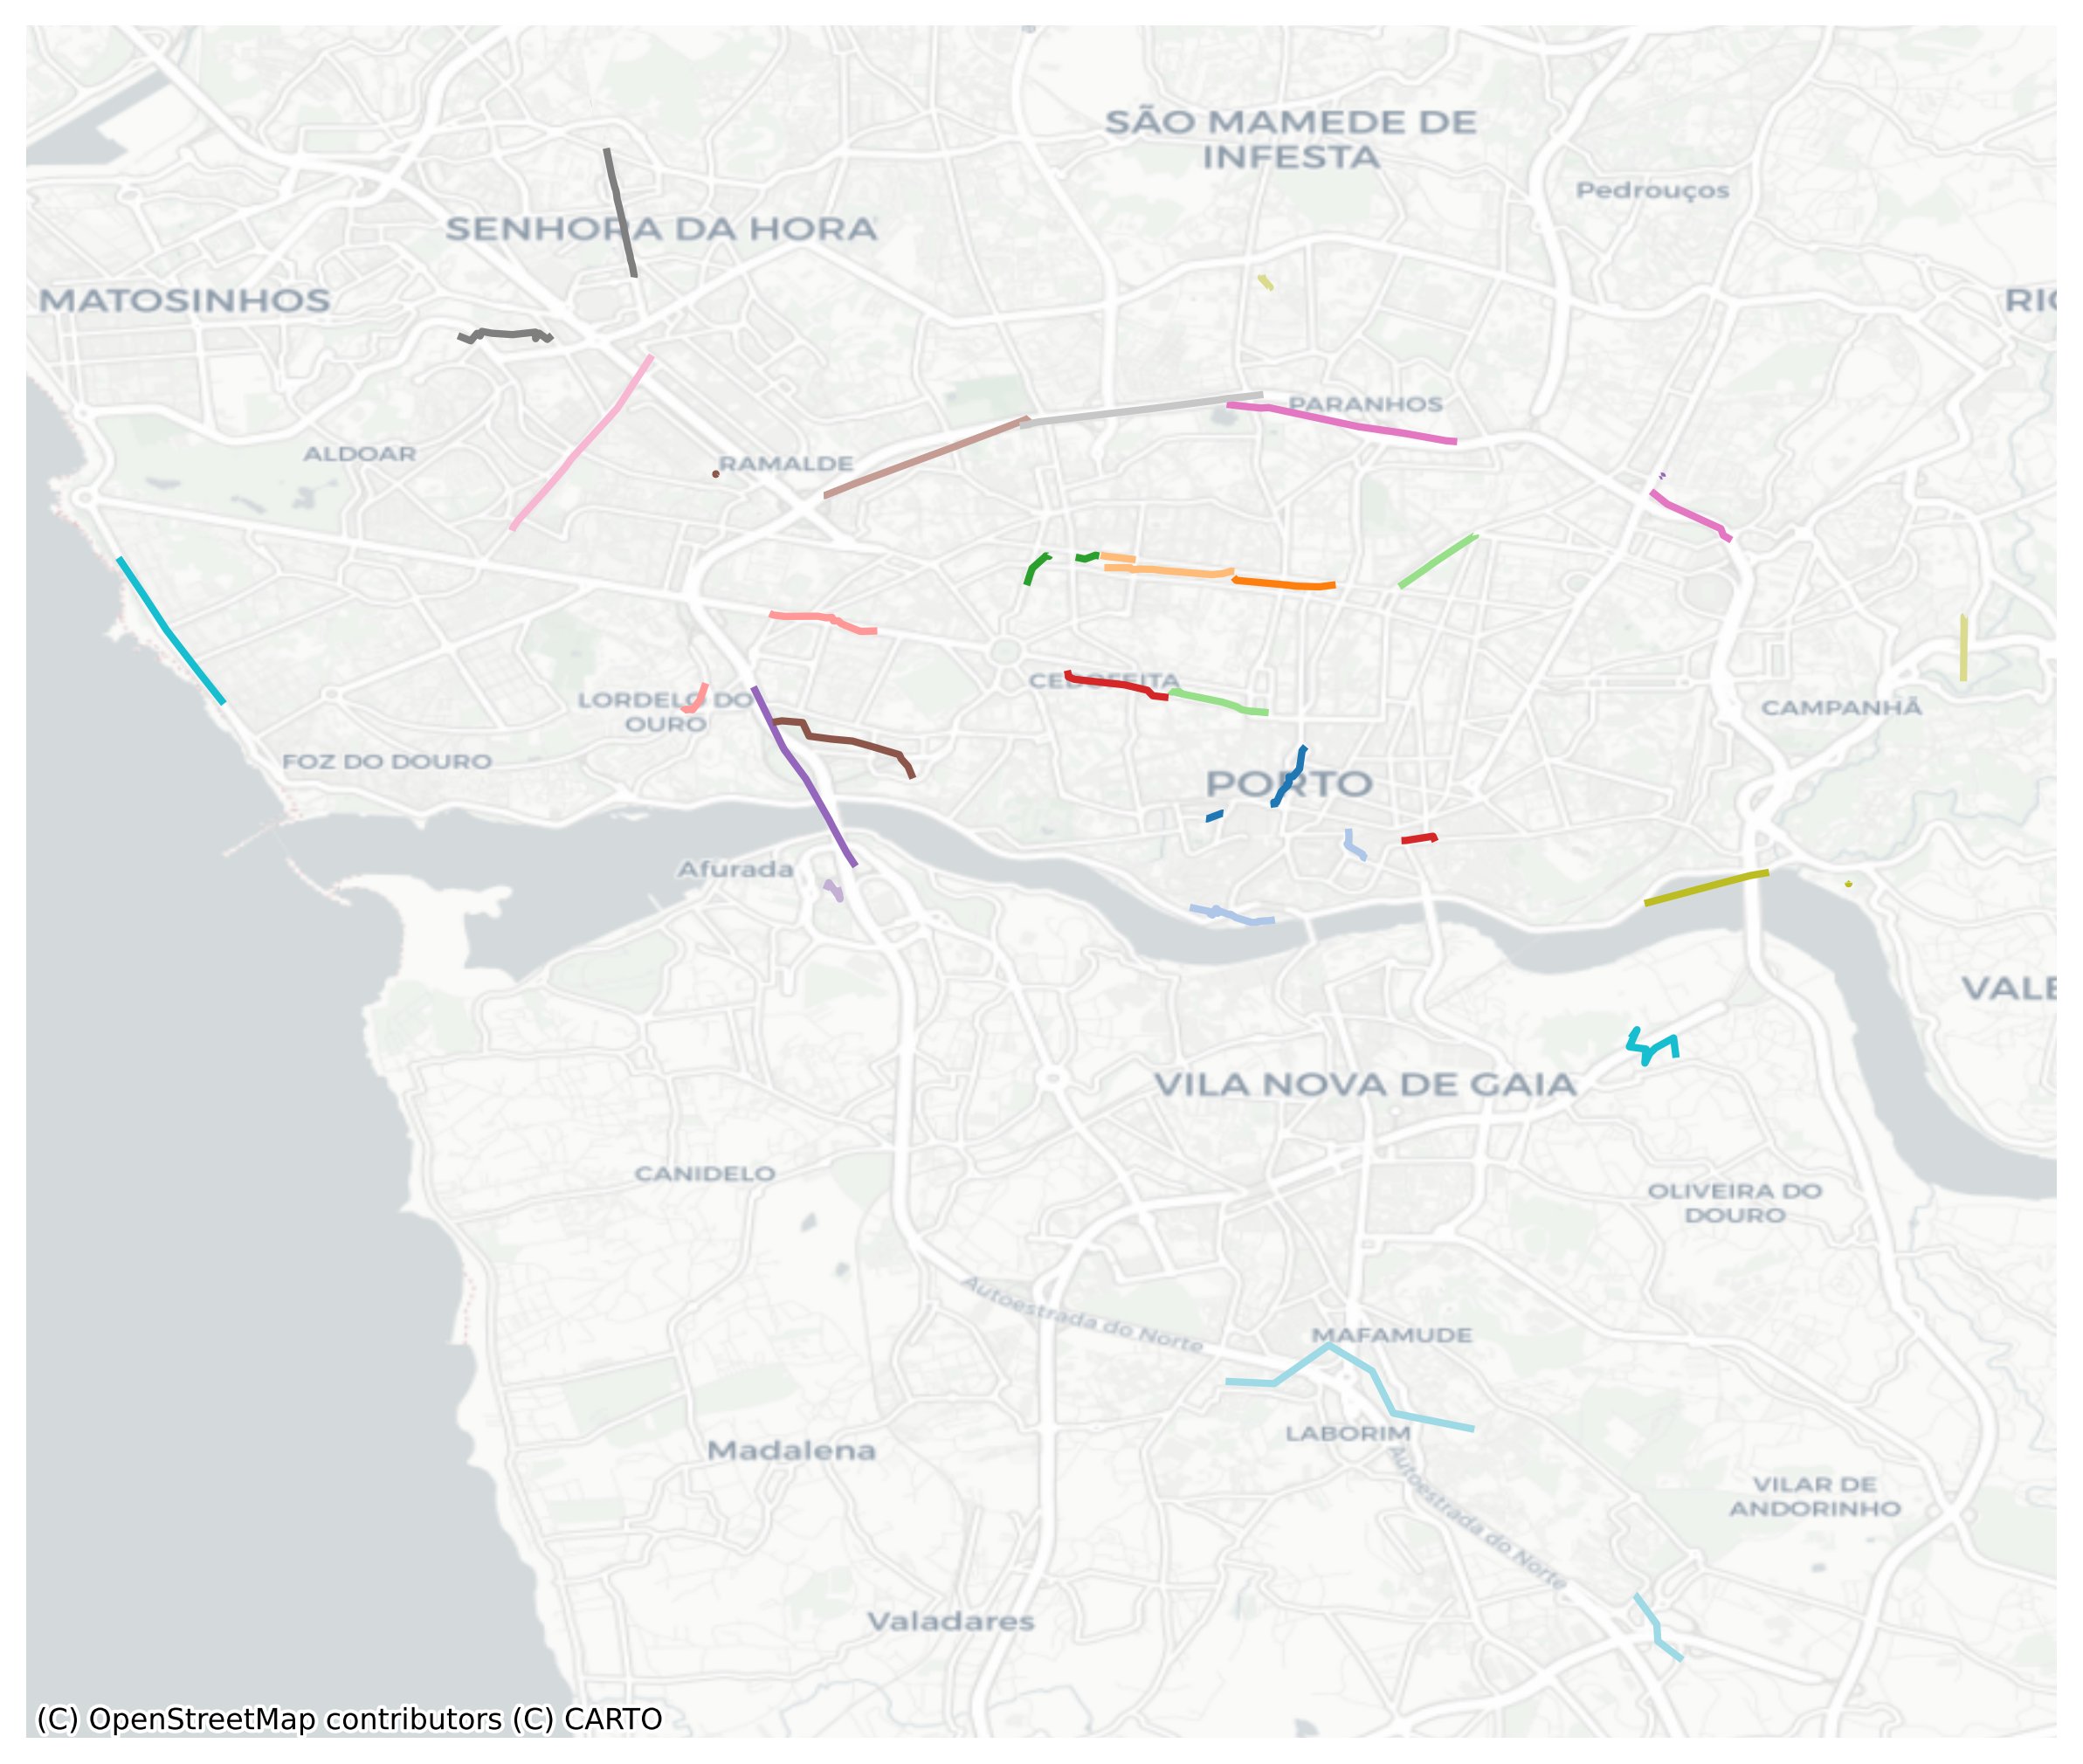

In [56]:
plot_map_colour(representative_clusters)